# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

from tensorflow import keras

from pycytominer.cyto_utils import infer_cp_features

sys.path.insert(0, "../../scripts")
from utils import load_data
from vae import VAE
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubun

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

<IPython.core.display.Javascript object>

In [4]:
data_splits = ["train", "test", "complete"]
data_dict = load_data(data_splits)

<IPython.core.display.Javascript object>

In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


<IPython.core.display.Javascript object>

In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(9331, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.62315,0.55849,0.62624,0.51999,0.57409,0.31956,0.46171,0.88474,0.67225,0.64383,...,0.11590,0.19604,0.16982,0.19072,0.59720,0.48635,0.44133,0.34020,0.38698,0.36443
1,0.57389,0.57043,0.65786,0.67567,0.59007,0.18635,0.54358,0.80395,0.75703,0.86697,...,0.68610,0.49445,0.48623,0.52409,0.52790,0.45707,0.53179,0.35976,0.42251,0.39983
2,0.58250,0.57720,0.58371,0.49209,0.59359,0.27266,0.48635,0.84295,0.65824,0.68948,...,0.13216,0.21838,0.20082,0.21740,0.57761,0.47538,0.42930,0.32904,0.36852,0.34152


<IPython.core.display.Javascript object>

In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.59217,0.55561,0.63066,0.47757,0.55035,0.33562,0.46515,0.86911,0.67738,0.67006,...,0.19597,0.25133,0.22358,0.26002,0.51224,0.41720,0.41433,0.28298,0.33171,0.30675
1,0.54204,0.58025,0.60367,0.49949,0.52929,0.29894,0.50218,0.84206,0.67566,0.91269,...,0.74574,0.54556,0.51850,0.58905,0.43406,0.32724,0.48337,0.20707,0.25478,0.23020
2,0.63760,0.51803,0.60673,0.51689,0.56349,0.26396,0.49172,0.90049,0.66206,0.69899,...,0.17822,0.23746,0.21804,0.24485,0.56227,0.47014,0.40165,0.32078,0.36857,0.34498


<IPython.core.display.Javascript object>

In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


<IPython.core.display.Javascript object>

In [9]:
# VAE of one layer
encoder_architecture = []
decoder_architecture = []



<IPython.core.display.Javascript object>

In [10]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=5,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=14,
    learning_rate=0.01,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<IPython.core.display.Javascript object>

In [11]:
cp_vae.train(x_train=train_features_df, x_test=test_features_df)

Train on 9331 samples, validate on 1037 samples
Epoch 1/14
9331/9331 [==============================] - 3s 280us/sample - loss: 386.7778 - val_loss: 384.6507
Epoch 2/14
9331/9331 [==============================] - 2s 220us/sample - loss: 384.4280 - val_loss: 383.2582
Epoch 3/14
9331/9331 [==============================] - 2s 219us/sample - loss: 383.2631 - val_loss: 382.7699
Epoch 4/14
9331/9331 [==============================] - 2s 226us/sample - loss: 383.2533 - val_loss: 382.8347
Epoch 5/14
9331/9331 [==============================] - 2s 223us/sample - loss: 383.1915 - val_loss: 382.7781
Epoch 6/14
9331/9331 [==============================] - 2s 224us/sample - loss: 383.1338 - val_loss: 382.9604
Epoch 7/14
9331/9331 [==============================] - 2s 225us/sample - loss: 383.0870 - val_loss: 382.8030
Epoch 8/14
9331/9331 [==============================] - 2s 217us/sample - loss: 383.0610 - val_loss: 382.6707
Epoch 9/14
9331/9331 [==============================] - 2s 222us/sample 

<IPython.core.display.Javascript object>

In [12]:
cp_vae.vae

<IPython.core.display.Javascript object>

In [13]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,val_loss
0,386.777812,384.650686
1,384.427958,383.258233
2,383.263090,382.769934
3,383.253304,382.834690
4,383.191528,382.778116
5,383.133789,382.960436
6,383.087048,382.803048
7,383.060962,382.670721
8,382.990230,382.768843
9,382.987012,382.616830


<IPython.core.display.Javascript object>

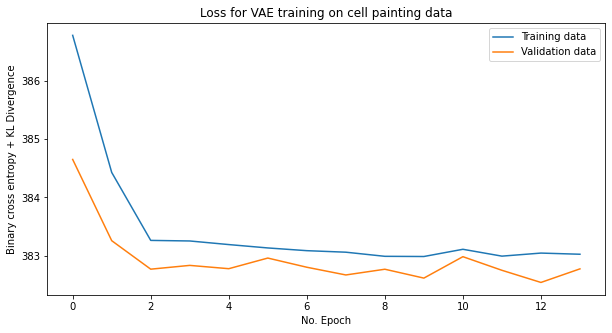

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on cell painting data")
plt.ylabel("Binary cross entropy + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [15]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

59.53502370366404

<IPython.core.display.Javascript object>

<AxesSubplot:>

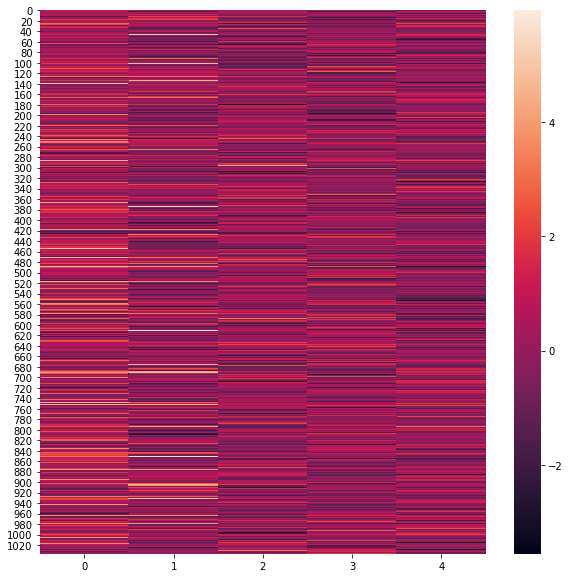

<IPython.core.display.Javascript object>

In [16]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

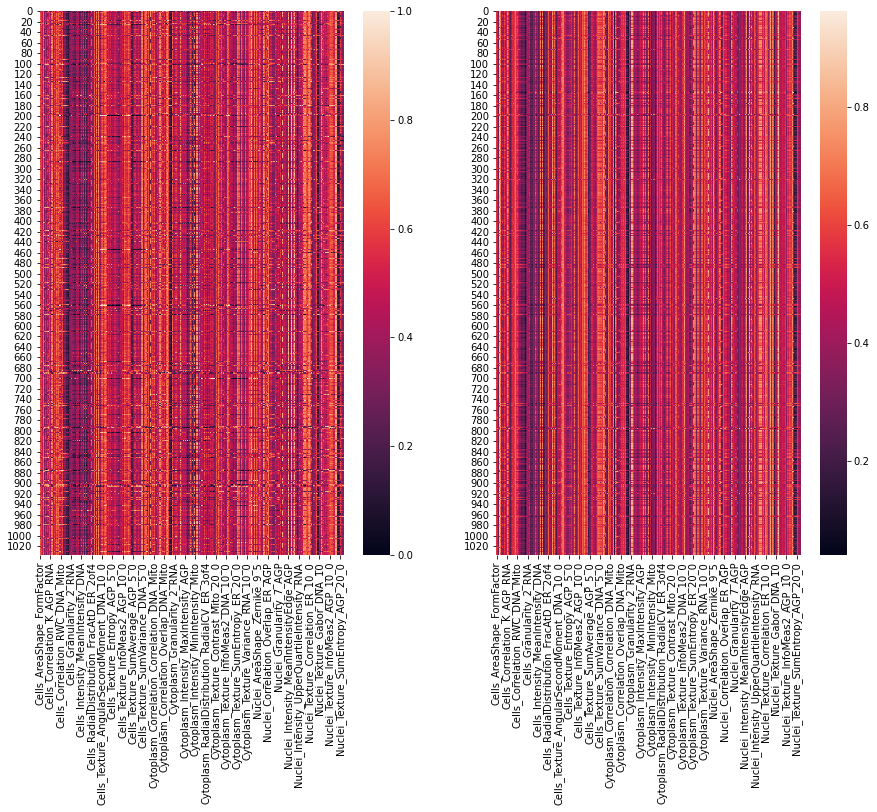

<IPython.core.display.Javascript object>

In [17]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
seaborn.heatmap(test_features_df, ax=ax1)
seaborn.heatmap(reconstruction, ax=ax2)
plt.show()

<AxesSubplot:>

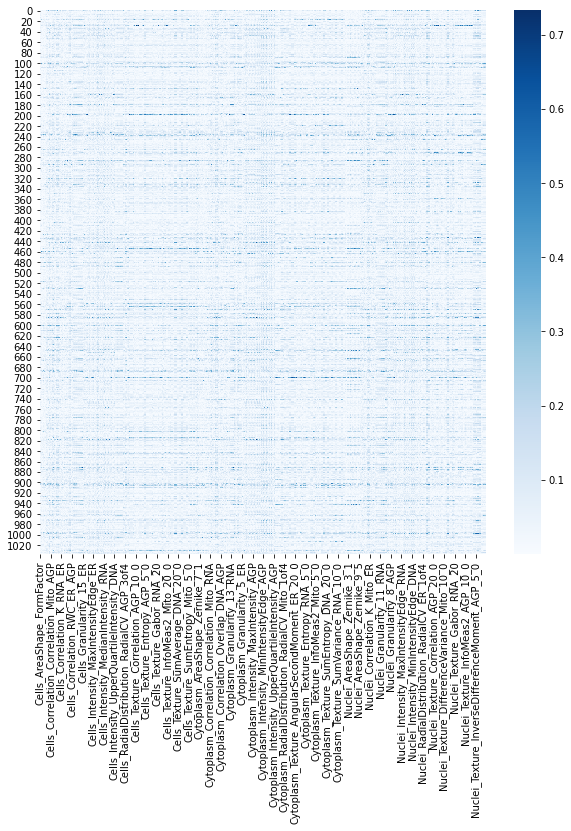

<IPython.core.display.Javascript object>

In [18]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

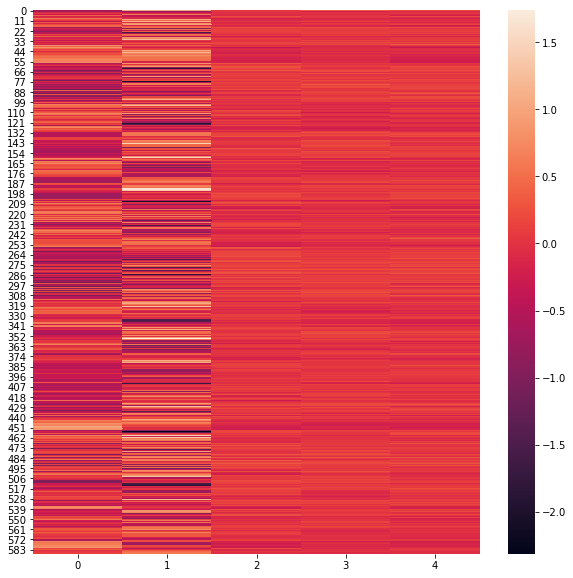

<IPython.core.display.Javascript object>

In [19]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [20]:
latent_dims = np.arange(1,51)
reconstructions = []

for latent_dim in latent_dims:
    cp_vae2 = VAE(
        input_dim=train_features_df.shape[1],
        latent_dim=latent_dim,
        batch_size=32,
        encoder_batch_norm=True,
        epochs=14,
        learning_rate=0.01,
        encoder_architecture=encoder_architecture,
        decoder_architecture=decoder_architecture,
        beta=1,
        verbose=True,
    )
    cp_vae2.compile_vae()
    cp_vae2.train(x_train=train_features_df, x_test=test_features_df)
    reconstruction = pd.DataFrame(cp_vae2.vae.predict(test_features_df), columns=cp_features)
    reconstructions.append(reconstruction)


Train on 9331 samples, validate on 1037 samples
Epoch 1/14
9331/9331 [==============================] - 3s 283us/sample - loss: 386.8156 - val_loss: 384.9804
Epoch 2/14
9331/9331 [==============================] - 2s 201us/sample - loss: 384.6835 - val_loss: 384.2430
Epoch 3/14
9331/9331 [==============================] - 2s 201us/sample - loss: 384.6338 - val_loss: 384.2625
Epoch 4/14
9331/9331 [==============================] - 2s 200us/sample - loss: 384.6021 - val_loss: 384.2568
Epoch 5/14
9331/9331 [==============================] - 2s 196us/sample - loss: 384.6845 - val_loss: 384.2325
Epoch 6/14
9331/9331 [==============================] - 2s 202us/sample - loss: 384.6281 - val_loss: 384.3019
Epoch 7/14
9331/9331 [==============================] - 2s 194us/sample - loss: 384.6418 - val_loss: 384.3936
Epoch 8/14
9331/9331 [==============================] - 2s 199us/sample - loss: 384.5562 - val_loss: 384.3447
Epoch 9/14
9331/9331 [==============================] - 2s 199us/sample 

In [21]:
frobenius_norms = []
for reconstruction in reconstructions:
    frobenius_norms.append(
        (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
    )

<IPython.core.display.Javascript object>

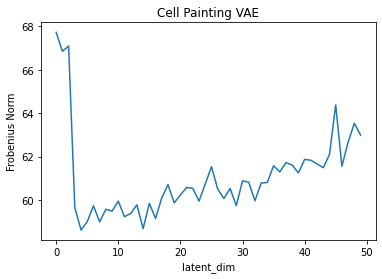

<IPython.core.display.Javascript object>

In [23]:
plt.plot(frobenius_norms)
plt.xlabel("latent_dim")
plt.ylabel("Frobenius Norm")
plt.title("Cell Painting VAE")
plt.show()

In [24]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
# latent_complete = np.array(encoder.predict(complete_features_df)[2])
# latent_df = pd.DataFrame(latent_complete)
# latent_df.to_csv("../3.application/latent.csv")

<IPython.core.display.Javascript object>

In [25]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
# decoder = cp_vae.decoder_block["decoder"]
# decoder.save("decoder")

<IPython.core.display.Javascript object>